# 2. Валидация данных. Методы валидации

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

В этом модуле мы будем решать задачу классификации: классифицировать воду на пригодную и непригодную для питья на основе её химического состава.

Скачать набор данных можно здесь. С подробным описанием датасета и столбцов таблицы ознакомьтесь в [источнике](https://www.kaggle.com/datasets/adityakadiwal/water-potability).

Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

In [3]:
water_data = pd.read_csv('data/water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода непригодна для питья.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [5]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:



In [6]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [7]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

Для примера разделим выборку в соотношении 80/20 (test_size=0.2), в качестве значения параметра random_state по традиции возьмём число 42.

Функция вернёт четыре массива:

таблицу X с обучающими примерами,
таблицу X с примерами для валидации,
столбец y с ответами на обучающие примеры,
столбец y с ответами на валидационные примеры.

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

Проверим размеры полученных выборок:

In [9]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
  
## Train shape: (2620, 9)
## Valid shape: (656, 9)

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid).

В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 
 
# Train hold-out accuracy: 0.82
# Valid hold-out accuracy: 0.77

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [11]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Выводим размерности полученных выборок:

In [12]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

## Train shape: (2620, 9)
## Valid shape: (328, 9)
## Test shape: (328, 9)

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

Реализация метода в sklearn

В библиотеке sklearn метод k-fold реализован в классе KFold.

Основные параметры инициализатора KFold:

n_split — число фолдов (число k из метода k-fold). По умолчанию — 5.
shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.
У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
обучать дерево решений;
делать предсказания для текущих тренировочной и валидационной выборок;
рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.
Код будет выглядеть следующим образом:

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

Выведем содержимое массивов train_metrics и val_metrics:



In [14]:
print(train_metrics)
print(val_metrics)
 
## [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
## [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики accuracy на кросс-валидации равно 0.81 для тренировочных фолдов и 0.74 — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на валидационных фолдах (если не предусмотрена тестовая выборка). 


Примечание. Если количество фолдов больше 30, вы можете построить доверительный интервал для среднего значения метрики.

Согласитесь, сложновато — не совсем в стиле sklearn. Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

estimator — модель, качество которой будет проверяться на кросс-валидации.
X — матрица наблюдений.
y — вектор-столбец правильных ответов.
cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.


Функция возвращает словарь со следующими ключами:

fit_time — время обучения модели на каждой итерации кросс-валидации;
score_time — время вычисления метрик на каждой итерации кросс-валидации;
test_score — значения метрик на валидационных фолдах;
train_score — значения метрик на тренировочных фолдах.
Итоговый код с использованием функции cross_validate() будет выглядеть следующим образом:

In [16]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.18986583, 0.08082175, 0.14514732, 0.15881777, 0.0870595 ]),
 'score_time': array([0.00801373, 0.01145864, 0.00564361, 0.0167973 , 0.00424123]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [17]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

### Реализация метода leave-one-out в sklearn

В библиотеке sklearn метод leave-one-out реализован в классе LeaveOneOut. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с KFold, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса LeaveOneOut также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

Примечание. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


Примечание. Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

Проблемы, которые могут возникнуть из-за несбалансированной выборки:

При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.
Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Взглянем на соотношение классов внутри датасета:

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

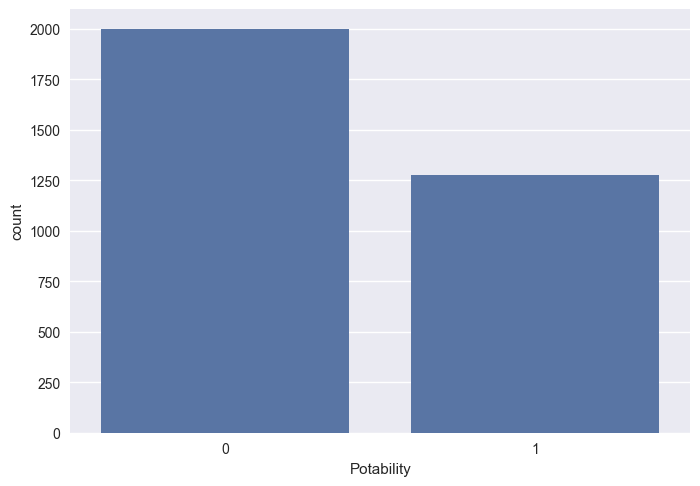

In [19]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Итак, около 61 % образцов воды являются непригодными для питья и 39 % являются пригодными. На самом деле, это небольшой дисбаланс классов (61/39). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например 80/20, 90/10 или даже 99/1. Как работать с такими данными, обсудим далее.

Рассмотрим особенности разбиения выборок в условиях дисбаланса классов.

СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [23]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid:
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 57/43. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [21]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — 61/39. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [22]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate().

ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

class weight(majority)=1,

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

class weight(minority)=1+nmajority/nminority,

где nminority и nmajority число — объектов в миноритарном и мажоритарном классах соответственно. Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений:

In [27]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       373
           1       0.76      0.68      0.72       283

    accuracy                           0.77       656
   macro avg       0.77      0.76      0.76       656
weighted avg       0.77      0.77      0.77       656



Так гораздо лучше! Обратите внимание на метрики класса 1: значение F1 поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики F1=2∗precision∗recall(recall+precision) для класса 1 (питьевая вода).

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [28]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

#y_cv_proba_pred

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [29]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [30]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F1-score.

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

Best threshold = 0.33, F1-Score = 0.69


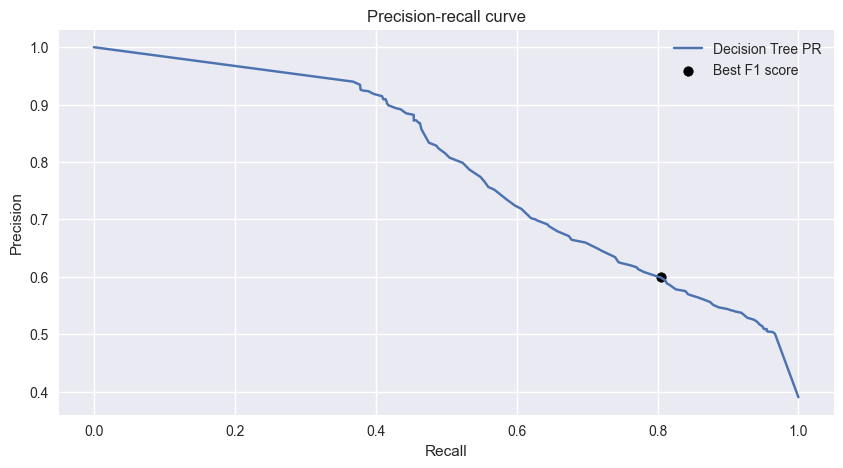

In [31]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум F1 (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [32]:
#Задаём оптимальный порог вероятностей
#threshold_opt = 0.33
threshold_opt = thresholds[idx]
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Итак, при применении метода подбора вероятности увеличилось значение метрик recall и F1 для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

In [33]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

PR AUC: 0.79


СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

Мы не будем сейчас заострять внимание на математической работе алгоритма, и вместо этого посмотрим на 2D-анимацию работы данного метода:



In [34]:
!pip install imbalanced-learn

Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:



In [35]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:


#Создаём объект класса SMOTE
smote = SMOTE(random_state=42)
#Сэмплируем обучающую выборку
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [36]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
Potability
0    1598
1    1022
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
Potability
0    1598
1    1598
Name: count, dtype: int64


Итак, размер выборки увеличился с 2620 примеров до 3196, и теперь количество наблюдений каждого из классов одинаково (1598/1598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [37]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Основные способы отследить переобучение:

hold-out-разбиение,
k-fold-валидация и leave-one-out-валидация,
кривые обучения (learning curves).
О них мы поговорим в следующем юните.
Если качество на валидационной выборке стабильно хуже качества на тренировочной, то это явный признак переобучения.

Рассмотрим пример. Будем использовать тот же набор данных об образцах воды.

Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику F1-score:

In [38]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

Train F1 score: 1.00
Valid F1 score: 0.67


Значение F1-score на тренировочной выборке показывает, что задача классификации образцов воды на пригодные и непригодные для питья решена идеально. Метрика равна максимуму — 1, а значит, и precision и recall для каждого из классов равны 1 (значит, и значения всех остальных метрик тоже максимальны). То есть модель правильно определила класс для всех образцов воды из набора данных.
Однако значение F1-score, полученное на валидационной выборке, менее оптимистично. Значение метрики на контроле значительно ниже, чем при обучении.
Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, поэтому результаты на контроле оставляют желать лучшего.

Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику F1 на тренировочных и валидационных фолдах.

In [39]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02654886, 0.02384639, 0.02682185, 0.02697682, 0.0245688 ]),
 'score_time': array([0.00252175, 0.00228572, 0.00203085, 0.00195694, 0.00188375]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

В полученном словаре невооруженным глазом видно, что на тренировочных фолдах значения метрик равны 1, а вот на валидационных метриках ни разу не превысила значения 0.7.

Подсчитаем среднее значение F1-score на выборках:

In [40]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 1.00
## Valid k-fold mean f1: 0.65

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


Сначала необходимо разобраться в причине переобучения модели. Для дерева решений установленный по умолчанию параметр max_depth будет означать, что дерево будет делиться до тех пор, пока не определит правильный класс для каждого объекта из обучающего набора данных.

На реальных данных, подверженных зашумлённости, такой подход в большинстве случаев приводит к переобучению дерева: глубина становится очень большой, и дерево не отражает общих зависимостей в данных.

В таком случае в первую очередь прибегают к «обрезке» деревьев путём ограничения максимальной глубины и/или увеличения количества объектов, при которых вершина дерева превращается в лист и деление прекращается.

In [41]:
print('Current depth:', model_bad.get_depth())
## Current depth: 27

Current depth: 27


Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [42]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


## Train k-fold mean f1: 0.75
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


После ограничения максимальной глубины удалось уменьшить разницу между метриками на тренировочных и валидационных фолдах кросс-валидации.

Попробуйте самостоятельно изменять глубину дерева в большую и меньшую сторону и проследите, как меняется значение метрик на кросс-валидации.

Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

Напомним интерпретацию данного параметра. Пусть min_samples_leaf=5. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (6 > min_samples_leaf), а первая вершина (4 < min_samples_leaf) дерева превратится в лист, и её деление будет остановлено.

In [43]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


Нам удалось ещё немного сократить разницу между метриками на тренировочных и валидационных фолдах и уменьшить переобучение.

Примечание. В приведённом выше примере мы выбирали параметры исключительно по принципу «холодно-горячо». Конечно же, в реальности никто так не делает — существуют специальные механизмы перебора комбинаций внешних параметров модели, и мы познакомимся с ними в отдельном модуле.

ПОСТРОЕНИЕ КРИВОЙ ОБУЧЕНИЯ

Давайте научимся строить кривые обучения с помощью Python. 

Для вычисления точек для построения кривых обучения в модуле model_selection библиотеки sklearn есть функция learning_curve().

Основные параметры функции learning_curve():

estimator — модель, качество которой будет проверяться на кросс-валидации.
X — матрица наблюдений.
y — вектор-столбец правильных ответов.
train_sizes — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. Если dtype имеет значение float, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т. е. он должен быть в пределах (0, 1].
По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], то есть для построения кривой обучения используется пять точек. Первая точка кривой обучения строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и так далее до тех пор, пока в построении модели не будет участвовать весь обучающий набор данных.
cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация k-fold на пяти фолдах.
scoring — название метрики в виде строки либо функция для её вычисления.
Если передать функции все необходимые параметры, она вернёт три массива:

Список из размеров тренировочного набора (ось абсцисс кривой обучения).
Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.
Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.
Код для вычисления координат будет иметь следующий вид:

In [44]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [45]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)
 
## Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
## Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


Теперь можно построить графики кривых обучения:

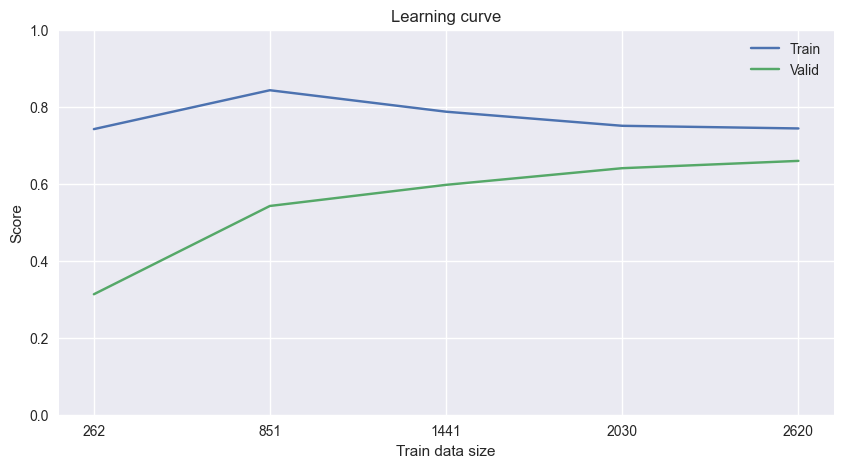

In [46]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

Видно, что в процессе увеличения количества наблюдений в обучающем наборе данных, метрики на тренировочной и валидационной выборках постепенно приближаются друг к другу, то есть уменьшается разброс (variance).

На финальном этапе, при использовании всех 2620 наблюдений из обучающей выборки, разница в показателях между тренировочной и валидационной выборками всё ещё присутствует, однако эту разницу можно принять как случайную.

Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию plot_learning_curve(). У функции будет несколько аргументов: модель, набор данных (X, y), кросс-валидатор, метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

In [49]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Примечание. Вы можете сохранить написанную нами функцию и обращаться к ней в своих задачах. Она не раз вам пригодится в исследованиях.

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели:

логистическую регрессию,
дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
дерево решений без ограничений.
Создадим список, в котором будем хранить эти модели:

In [50]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

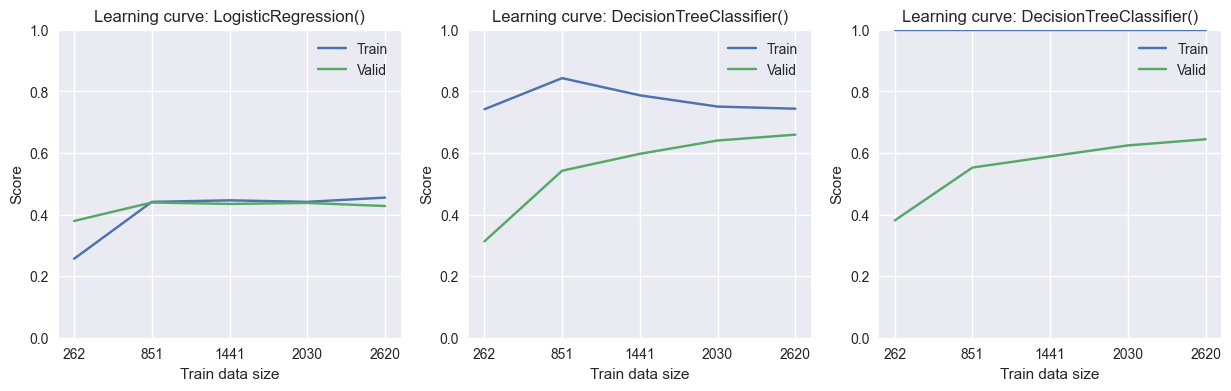

In [51]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

Благодаря построенным графикам мы можем легко сравнить три представленные модели между собой. 

Первый график, построенный для логистической регрессии, говорит нам о том, что для данной модели качество на тренировочных и валидационных фолдах практически одинаково (кривые проходят очень близко друг к другу), то есть переобучения нет. Однако данная модель обладает низким качеством: кривые не превышают даже значения 0.5. Модель является недообученнной.
Третий график, построенный для дерева решений без ограничений глубины, явно указывает на наличие переобучения: тренировочная кривая всё время находится в области своего максимума — 1, а вот валидационная кривая не может достичь такой высокой отметки.
Из всех представленных оптимальной является модель дерева решений с ограничениями, кривая обучения которой изображена на втором графике. Тренировочная и валидационная кривые постепенно сходятся к единой отметке качества, и полученная метрика превышает отметку в 0.5.